## First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

#**Final Project for Coursera's 'How to Win a Data Science Competition'**
April, 2020

Andreas Theodoulou and Michael Gaidis

(Competition Info last updated:  3 years ago)

##**About this Competition**

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Evaluation: root mean squared error (RMSE). True target values are clipped into [0,20] range.

.

##**File descriptions**

***sales_train.csv*** - the training set. Daily historical data from January 2013 to October 2015.

***test.csv*** - the test set. You need to forecast the sales for these shops and products for November 2015.

***sample_submission.csv*** - a sample submission file in the correct format.

***items.csv*** - supplemental information about the items/products.

***item_categories.csv***  - supplemental information about the items categories.

***shops.csv***- supplemental information about the shops.

.

##**Data fields**

***ID*** - an Id that represents a (Shop, Item) tuple within the test set

***shop_id*** - unique identifier of a shop

***item_id*** - unique identifier of a product

***item_category_id*** - unique identifier of item category

***item_cnt_day*** - number of products sold. You are predicting a monthly amount of this measure

***item_price*** - current price of an item

***date*** - date in format dd/mm/yyyy

***date_block_num*** - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

***item_name*** - name of item

***shop_name*** - name of shop

***item_category_name*** - name of item category

#Load Files
Load competition data files and import helpful custom code libraries from shared GitHub repository

In [0]:
# GitHub file location info
git_hub_url = "https://raw.githubusercontent.com/migai/"
repo_name = 'Kag/'
branch_name = 'master/'
base_url = git_hub_url + repo_name + branch_name

# List of the data files (path relative to GitHub branch), to be loaded into pandas DataFrames
data_files = [  "readonly/final_project_data/items.csv",
                "readonly/final_project_data/item_categories.csv",
                "readonly/final_project_data/shops.csv",
                "readonly/final_project_data/sample_submission.csv.gz",
                "readonly/final_project_data/sales_train.csv.gz",
                "readonly/final_project_data/test.csv.gz"  
              ]

# List of helper code files, to be loaded into Colab and available for python import
code_files = ["kaggle_utils_at_mg.py"]

In [2]:
import pandas as pd
import os

def xfer_github_to_colab(path):
    filename = path.rsplit("/")[-1]
    os.system("wget " + base_url + "{} -O {}".format(path, filename))
    print(base_url + path + " ---> loaded into ---> " + filename)
    return filename

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False


if IN_COLAB:
    print("Loading Files from GitHub to Colab\n")

    # Loop to load the above data files into appropriately-named pandas DataFrames
    for path_name in data_files:
      filename = xfer_github_to_colab(path_name)
      data_frame_name = path_name.rsplit("/")[-1].split(".")[0]
      exec(data_frame_name + " = pd.read_csv(filename)")
      print("Data Frame: " + data_frame_name)
      print(eval(data_frame_name).head(2))
      print("\n")


    # to load a code (".py") file into Colab, first shred to make sure you aren't using an old version
    for path_name in code_files:
      filename = path_name.rsplit("/")[-1]
      ! shred -u {filename}
      filename = xfer_github_to_colab(path_name)

Loading Files from GitHub to Colab

https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/items.csv ---> loaded into ---> items.csv
Data Frame: items
                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76


https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/item_categories.csv ---> loaded into ---> item_categories.csv
Data Frame: item_categories
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1


https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/shops.csv ---> loaded into ---> shops.csv
Data Frame: shops
                       shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1


https://ra

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag/data_output')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#if running locally
'''
import os
try: 
  os.chdir('/Users/andreastheodoulou/Desktop/Github/Kag')
except:
  pass
data_files = [  "readonly/final_project_data/items.csv",
                "readonly/final_project_data/item_categories.csv",
                "readonly/final_project_data/shops.csv",
                "readonly/final_project_data/sample_submission.csv.gz",
                "readonly/final_project_data/sales_train.csv.gz",
                "readonly/final_project_data/test.csv.gz"]

df_name = ['item', 'item_categories', 'shops', 'sample_submission', 'sales_train', 'test']
for i in range(len(data_files)):
  filename = data_files[i]
  data_frame_name = df_name[i]
  exec(data_frame_name + " = pd.read_csv(filename)")
  print("Data Frame: " + data_frame_name)
  print(eval(data_frame_name).head(2))
  print("\n")
  '''

'\nimport os\ntry: \n  os.chdir(\'/Users/andreastheodoulou/Desktop/Github/Kag\')\nexcept:\n  pass\ndata_files = [  "readonly/final_project_data/items.csv",\n                "readonly/final_project_data/item_categories.csv",\n                "readonly/final_project_data/shops.csv",\n                "readonly/final_project_data/sample_submission.csv.gz",\n                "readonly/final_project_data/sales_train.csv.gz",\n                "readonly/final_project_data/test.csv.gz"]\n\ndf_name = [\'item\', \'item_categories\', \'shops\', \'sample_submission\', \'sales_train\', \'test\']\nfor i in range(len(data_files)):\n  filename = data_files[i]\n  data_frame_name = df_name[i]\n  exec(data_frame_name + " = pd.read_csv(filename)")\n  print("Data Frame: " + data_frame_name)\n  print(eval(data_frame_name).head(2))\n  print("\n")\n  '

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import time
from sklearn.linear_model import LinearRegression
#from catboost import CatBoostRegressor
import pickle

#from catboost import CatBoostRegressor 

In [6]:
import os
from google.colab import drive
drive.mount('/content/drive')
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
os.chdir(gdrive_repo_path + '/data_output')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
sales_train_cleaned_mrg = pd.read_csv('sales_train_cln_mrg.csv.gz', compression = 'gzip')
sales_train = sales_train_cleaned_mrg
item_category_feature_mappings = pd.read_csv('items_new.csv').drop(['item_category3', 'item_category4'], axis = 1)
item_category_feature_mappings.columns = [x.strip().replace('_enc', '') for x in item_category_feature_mappings.columns]
shop_category_feature_mappings = pd.read_csv('shops_new.csv').drop(['shop_type', 'shop_city', 'shop_federal_district', 's_type_broad','fd_popdens', 'fd_gdp'], axis=1)
shop_category_feature_mappings.columns = [x.strip().replace('_enc', '') for x in shop_category_feature_mappings.columns]

item_category_features = item_category_feature_mappings.drop('item_id', axis =1).columns.tolist()
shop_category_features = shop_category_feature_mappings.drop('shop_id', axis =1).columns.tolist()
#test = pd.read_csv('test_mrg.csv.gz', compression = 'gzip')

In [8]:
sales_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'shop_tested', 'shop_type_enc', 'shop_city_enc',
       'shop_federal_district_enc', 's_type_broad_enc', 'fd_popdens_enc',
       'fd_gdp_enc', 'item_tested', 'item_category_id', 'cluster_code',
       'item_category3_enc', 'item_category4_enc'],
      dtype='object')

In [9]:
'''
shop_category_features = ['shop_type_enc', 'shop_city_enc',
       'shop_federal_district_enc', 's_type_broad_enc']
item_category_features = ['item_category_id', 'cluster_code',
       'item_category3_enc', 'item_category4_enc']
item_category_feature_mappings = sales_train[item_category_features + ['item_id']].drop_duplicates('item_id')
shop_category_feature_mappings = sales_train[shop_category_features + ['shop_id']].drop_duplicates('shop_id')
item_category_feature_mappings.head()
'''

"\nshop_category_features = ['shop_type_enc', 'shop_city_enc',\n       'shop_federal_district_enc', 's_type_broad_enc']\nitem_category_features = ['item_category_id', 'cluster_code',\n       'item_category3_enc', 'item_category4_enc']\nitem_category_feature_mappings = sales_train[item_category_features + ['item_id']].drop_duplicates('item_id')\nshop_category_feature_mappings = sales_train[shop_category_features + ['shop_id']].drop_duplicates('shop_id')\nitem_category_feature_mappings.head()\n"

Helpful functions

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in range(len(lags)):
        shifted_df = tmp.copy()
        shifted_df.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(lags[i])]
        shifted_df['date_block_num'] += lags[i]   
        if i == 0:
          shifted_df_merged = shifted_df
        else:
          shifted_df_merged = pd.merge(shifted_df_merged, shifted_df, on=['date_block_num','shop_id','item_id'], how='left')
        
    return shifted_df_merged

import numpy as np
def downcast_df(data):
  cols_not_to_downcast = ['item_id', 'ID', 'sales_sum_by_month', 'cluster_code']
  for col in data.columns:
    col_type = data[col].dtype
    if np.issubdtype(col_type, np.integer):
      if col in cols_not_to_downcast:
        data[col] = data[col].astype(np.int32)
      else:    
        data[col] = data[col].astype(np.int8)
    elif np.issubdtype(col_type, np.floating):
      if col in cols_not_to_downcast:
        data[col] = data[col].astype(np.float32)
      else:    
        data[col] = data[col].astype(np.float16)
    else:
      pass
  return data

def upcast_df(data):
  cols_not_to_downcast = ['item_id', 'ID']
  for col in data.columns:
    col_type = data[col].dtype
    if np.issubdtype(col_type, np.integer):
      if col in cols_not_to_downcast:
        data[col] = data[col].astype(np.int32)
      else:    
        data[col] = data[col].astype(np.int32)
    elif np.issubdtype(col_type, np.floating):
      data[col] = data[col].astype(np.float64)
    else:
      pass
  return data


def infer_variable_types(data):
  variable_types = {'categorical': [], 'numerical': []}
  for col in data.columns:
    col_type = data[col].dtype
    if np.issubdtype(col_type, np.integer):
      variable_types['categorical'].append(col)
    elif np.issubdtype(col_type, np.floating):
      variable_types['numerical'].append(col)
    else:
      pass
  return variable_types 

def sort_variable_types(data, categorical_cols, numerical_cols):
  cols_not_to_downcast = ['item_id', 'ID']
  for col in data.columns:
    if col in categorical_cols:
      if col in cols_not_to_downcast:
        data[col] = data[col].astype(np.int32)
      else:    
        data[col] = data[col].astype(np.int8)
    elif col in numerical_cols:
      data[col] = data[col].astype(np.float16)
    else:
      pass
  return data

# **Data Preparation**

*   Make data table monthly from daily (is there any point in using the daily data in more advanced modelling versions? Probably just to create more relevant monthly related features (e.g. mean/std or any other type) rather than keeping the format of the table daily)
*   To do: Merge item_category_id as a feature




Make monthly table ("matrix") of Shop-Item pairs (using cartesian product of date_block_num, shop_id, item_id)

In [11]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)

matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
print("monthly table is")
matrix.head()


monthly table is


,date_block_num,shop_id,item_id
114770,0,2,19
117010,0,2,27
120478,0,2,28
118176,0,2,29
114462,0,2,32


Include test set  - and its test IDs (of shop-item pairs) given from test.csv[link text

In [12]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
matrix['ID'] = matrix['ID'].astype(np.int32)

matrix

,date_block_num,shop_id,item_id,ID
0,0,2,19,0
1,0,2,27,0
2,0,2,28,0
3,0,2,29,0
4,0,2,32,0
...,...,...,...,...
10929574,34,45,18454,214195
10929575,34,45,16188,214196
10929576,34,45,15757,214197
10929577,34,45,19648,214198


Add monthly item_count (sales) to the monthly table

In [13]:
ts = time.time()
monthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
monthly_sales.columns = ['item_cnt_month']
monthly_sales.reset_index(inplace=True)

matrix = pd.merge(matrix, monthly_sales, on=cols, how='left') #note this merge used to be how = 'left' at first (at first results of GBT) - in case anything doesn't work in the future keep in mind this was changed - might be root of a problem
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
matrix.tail()

,date_block_num,shop_id,item_id,ID,item_cnt_month
10929574,34,45,18454,214195,0.0
10929575,34,45,16188,214196,0.0
10929576,34,45,15757,214197,0.0
10929577,34,45,19648,214198,0.0
10929578,34,45,969,214199,0.0


Add item_category and shop_category features (created through analysis in other scripts)

In [14]:
matrix = pd.merge(matrix, item_category_feature_mappings, on=['item_id'], how='left')
matrix = pd.merge(matrix, shop_category_feature_mappings, on=['shop_id'], how='left')
matrix.head()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp
0,0,2,19,0,0.0,False,40,3278,7,3,True,30,10,32,60,31,25
1,0,2,27,0,1.0,False,19,2959,4,6,True,30,10,32,60,31,25
2,0,2,28,0,0.0,False,30,2253,4,5,True,30,10,32,60,31,25
3,0,2,29,0,0.0,False,23,2959,4,7,True,30,10,32,60,31,25
4,0,2,32,0,0.0,True,40,4055,7,3,True,30,10,32,60,31,25


In [15]:
matrix.tail()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp
10929574,34,45,18454,214195,0.0,True,55,3927,8,4,True,50,44,48,60,31,25
10929575,34,45,16188,214196,0.0,True,64,64,5,2,True,50,44,48,60,31,25
10929576,34,45,15757,214197,0.0,True,55,235,8,4,True,50,44,48,60,31,25
10929577,34,45,19648,214198,0.0,True,40,40,7,3,True,50,44,48,60,31,25
10929578,34,45,969,214199,0.0,True,37,5992,7,3,True,50,44,48,60,31,25


Understanding dataframe created ("matrix")



In [16]:
#NOTE: For item_category_features we have a very small percentage of null values (maybe a few item ids present in matrix, not mapped to an item category during analysis)
df = matrix
df1 = df.describe(include = 'all')

df1.loc['dtype'] = df.dtypes
df1.loc['size'] = len(df)
df1.loc['% null count'] = df.isnull().mean()
df1.loc['count of 0s'] = df.apply(lambda col: (col.count() - np.count_nonzero(col)))
df1

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp
count,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,10929579,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,10929579,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,7520218,NaN,NaN,NaN,NaN,9288503,NaN,NaN,NaN,NaN,NaN,NaN
mean,15.42,31.6716,11292.6,2098.96,NaN,NaN,44.9273,1810.87,6.08274,3.52385,NaN,39.4068,36.9442,41.9743,54.4272,35.708,39.3869
std,9.77544,17.3014,6208.24,17185,0,NaN,15.1474,2171.07,2.1201,1.4047,NaN,11.561,17.3266,17.3786,14.7446,21.818,11.1045
min,0,2,0,0,0,NaN,0,19,0,0,NaN,10,0,0,10,5,25
25%,7,17,5940,0,0,NaN,37,456,5,3,NaN,30,24,32,60,5,25
50%,15,31,11379,0,0,NaN,40,1242,7,3,NaN,40,42,48,60,31,43
75%,23,47,16577,0,0,NaN,55,2504,7,4,NaN,50,52,56,60,57,43


In [17]:
#Replace NaNs with 0
matrix.fillna(0, inplace=True)
#Convert data type - make categorical variables to integer type
matrix[item_category_features + shop_category_features] = matrix[item_category_features + shop_category_features].astype(int)
#Downcast variables (smaller memory size)
matrix = downcast_df(matrix)
matrix.head()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp
0,0,2,19,0,0.0,0,40,3278,7,3,1,30,10,32,60,31,25
1,0,2,27,0,1.0,0,19,2959,4,6,1,30,10,32,60,31,25
2,0,2,28,0,0.0,0,30,2253,4,5,1,30,10,32,60,31,25
3,0,2,29,0,0.0,0,23,2959,4,7,1,30,10,32,60,31,25
4,0,2,32,0,0.0,1,40,4055,7,3,1,30,10,32,60,31,25


In [18]:
matrix[item_category_features + shop_category_features] 

,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp
0,0,40,3278,7,3,1,30,10,32,60,31,25
1,0,19,2959,4,6,1,30,10,32,60,31,25
2,0,30,2253,4,5,1,30,10,32,60,31,25
3,0,23,2959,4,7,1,30,10,32,60,31,25
4,1,40,4055,7,3,1,30,10,32,60,31,25
...,...,...,...,...,...,...,...,...,...,...,...,...
10929574,1,55,3927,8,4,1,50,44,48,60,31,25
10929575,1,64,64,5,2,1,50,44,48,60,31,25
10929576,1,55,235,8,4,1,50,44,48,60,31,25
10929577,1,40,40,7,3,1,50,44,48,60,31,25


In [19]:
[item_category_features] + [shop_category_features]


[['item_tested',
  'item_category_id',
  'cluster_code',
  'item_category3',
  'item_category4'],
 ['shop_tested',
  'shop_type',
  'shop_city',
  'shop_federal_district',
  's_type_broad',
  'fd_popdens',
  'fd_gdp']]

In [20]:
#Basic demonstration of feature generation to follow
#mean of a item price or item count for the month with respect to items (will also do with respect to shops later)
group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean'],
                                                               'item_cnt_day': ['mean']})
group.columns = ['price_mean_by_item', 'sales_mean_by_item']
group

price_mean_by_item  sales_mean_by_item
date_block_num item_id                                        
0              19                28.000000            1.000000
               27              2325.000000            1.000000
               28               549.000000            1.000000
               29              2397.500000            0.666667
               32               341.318852            1.337900
...                                    ...                 ...
33             22162            349.000000            1.000000
               22163            162.698400            1.040000
               22164            549.000000            1.000000
               22166            150.000000            1.833333
               22167            293.098437            1.156250

[233471 rows x 2 columns]

In [21]:
#Option 2 for creating monthly dataset

#For some reason doesn't work as good as the "matrix" (cartesian product up to now)
#LightGBM results after feature generation are r2_score on validation of 0.06 as opposed to 0.3 that we receive with matrix method
'''
monthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
monthly_sales.columns = ['item_cnt_month']
monthly_sales.reset_index(inplace=True)
test['date_block_num'] = 34
monthly_sales = pd.concat([monthly_sales, test])
monthly_sales = pd.DataFrame.merge(monthly_sales,items[['item_category_id', 'item_id']],on='item_id')
monthly_sales.fillna(0, inplace=True) # 34 month
monthly_sales['ID'] = monthly_sales['ID'].astype(np.int32)
monthly_sales.head()
'''

"\nmonthly_sales = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})\nmonthly_sales.columns = ['item_cnt_month']\nmonthly_sales.reset_index(inplace=True)\ntest['date_block_num'] = 34\nmonthly_sales = pd.concat([monthly_sales, test])\nmonthly_sales = pd.DataFrame.merge(monthly_sales,items[['item_category_id', 'item_id']],on='item_id')\nmonthly_sales.fillna(0, inplace=True) # 34 month\nmonthly_sales['ID'] = monthly_sales['ID'].astype(np.int32)\nmonthly_sales.head()\n"

In [22]:
monthly_sales.tail()

,date_block_num,shop_id,item_id,item_cnt_month
1595419,33,59,22087,6
1595420,33,59,22088,2
1595421,33,59,22091,1
1595422,33,59,22100,1
1595423,33,59,22102,1


### **Featue Generation/Engineering**

Time series features
*   Statistics of previous months (e.g. mean of item_price for a specific item/shop in previous months)
*   Trends of previous months - rate of change of the above statistics based features (e.g. rate of change of mean item_price from today to the past 3 months for a specific shop/item)




Stage 1: Statistics based features

> 1st step: Compute their Values


In [23]:
#Compute sum, mean, std, and median of item price/item cnt for the below categories:
#include count of items sold in a shop (size of shop), count of days in the month)

#1)
#per date_block_num and item_id
monthly_sales_per_item = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']
                                                               })
monthly_sales_per_item.columns = ['price_mean_by_item', 'price_std_by_item', 'price_median_by_item',
                 'sales_sum_by_item', 'sales_mean_by_item', 'sales_std_by_item', 'sales_median_by_item']
monthly_sales_per_item.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_item, on=['date_block_num','item_id'], how='left')

#2)
#per date_block_num and shop_id
monthly_sales_per_shop = sales_train.groupby(['date_block_num','shop_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']})
monthly_sales_per_shop.columns = ['price_mean_by_shop', 'price_std_by_shop', 'price_median_by_shop',
                 'sales_sum_by_shop', 'sales_mean_by_shop', 'sales_std_by_shop', 'sales_median_by_shop']
monthly_sales_per_shop.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_shop, on=['date_block_num','shop_id'], how='left')

#3)
#per date_block_num and item_category
monthly_sales_per_item_category = sales_train.groupby(['date_block_num','item_category_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']})
monthly_sales_per_item_category.columns = ['price_mean_by_item_category', 'price_std_by_item_category', 'price_median_by_item_category',
                 'sales_sum_by_item_category', 'sales_mean_by_item_category', 'sales_std_by_item_category', 'sales_median_by_item_category']

monthly_sales_per_item_category.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_item_category, on=['date_block_num','item_category_id'], how='left')

#4)
#per date_block_num, item_id, and shop_id
monthly_sales_per_shop_and_item = sales_train.groupby(['date_block_num','item_id', 'shop_id']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']})
monthly_sales_per_shop_and_item.columns = ['price_mean_by_item_and_shop', 'price_std_by_item_and_shop', 'price_median_by_item_and_shop',
                 'sales_sum_by_item_and_shop', 'sales_mean_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop']

monthly_sales_per_shop_and_item.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_shop_and_item, on=['date_block_num','item_id', 'shop_id'], how='left')

#5)
#per date_block_num
monthly_sales_per_date_block = sales_train.groupby(['date_block_num']).agg({'item_price': ['mean', 'std', 'median'],
                                                               'item_cnt_day': ['sum', 'mean', 'std', 'median']})
monthly_sales_per_date_block.columns = ['price_mean_by_month', 'price_std_by_month', 'price_median_by_month',
                 'sales_sum_by_month', 'sales_mean_by_month', 'sales_std_by_month', 'sales_median_by_month']

monthly_sales_per_date_block.reset_index(inplace=True)
matrix = pd.merge(matrix, monthly_sales_per_date_block, on=['date_block_num'], how='left')

#WARNING: FIX DOWNCASTING FOR 'SALES_SUM_BY_MONTH' COL - it turns to inf with float16
matrix = downcast_df(matrix)

matrix

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item,price_std_by_item,price_median_by_item,sales_sum_by_item,sales_mean_by_item,sales_std_by_item,sales_median_by_item,price_mean_by_shop,price_std_by_shop,price_median_by_shop,sales_sum_by_shop,sales_mean_by_shop,sales_std_by_shop,sales_median_by_shop,price_mean_by_item_category,price_std_by_item_category,price_median_by_item_category,sales_sum_by_item_category,sales_mean_by_item_category,sales_std_by_item_category,sales_median_by_item_category,price_mean_by_item_and_shop,price_std_by_item_and_shop,price_median_by_item_and_shop,sales_sum_by_item_and_shop,sales_mean_by_item_and_shop,sales_std_by_item_and_shop,sales_median_by_item_and_shop,price_mean_by_month,price_std_by_month,price_median_by_month,sales_sum_by_month,sales_mean_by_month,sales_std_by_month,sales_median_by_month
0,0,2,19,0,0.0,0,40,3278,7,3,1,30,10,32,60,31,25,28.00,NaN,28.0,1.0,1.000000,NaN,1.0,960.5,1755.0,499.0,1146.0,1.070312,0.348145,1.0,246.0,126.50,199.0,32864.0,1.146484,0.708984,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715.5,1249.0,399.0,130301.0,1.136719,0.681152,1.0
1,0,2,27,0,1.0,0,19,2959,4,6,1,30,10,32,60,31,25,2324.00,297.2500,2500.0,7.0,1.000000,0.000000,1.0,960.5,1755.0,499.0,1146.0,1.070312,0.348145,1.0,1534.0,696.00,1499.0,8984.0,1.131836,0.555176,1.0,2500.0,NaN,2500.0,1.0,1.0,NaN,1.0,715.5,1249.0,399.0,130301.0,1.136719,0.681152,1.0
2,0,2,28,0,0.0,0,30,2253,4,5,1,30,10,32,60,31,25,549.00,0.0000,549.0,8.0,1.000000,0.000000,1.0,960.5,1755.0,499.0,1146.0,1.070312,0.348145,1.0,430.0,223.25,399.0,22112.0,1.199219,0.761719,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715.5,1249.0,399.0,130301.0,1.136719,0.681152,1.0
3,0,2,29,0,0.0,0,23,2959,4,7,1,30,10,32,60,31,25,2398.00,248.6250,2500.0,4.0,0.666504,0.816406,1.0,960.5,1755.0,499.0,1146.0,1.070312,0.348145,1.0,1844.0,554.50,1999.0,4152.0,1.080078,0.389648,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715.5,1249.0,399.0,130301.0,1.136719,0.681152,1.0
4,0,2,32,0,0.0,1,40,4055,7,3,1,30,10,32,60,31,25,341.25,30.3125,349.0,293.0,1.337891,0.875000,1.0,960.5,1755.0,499.0,1146.0,1.070312,0.348145,1.0,246.0,126.50,199.0,32864.0,1.146484,0.708984,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715.5,1249.0,399.0,130301.0,1.136719,0.681152,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10929574,34,45,18454,214195,0.0,1,55,3927,8,4,1,50,44,48,60,31,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10929575,34,45,16188,214196,0.0,1,64,64,5,2,1,50,44,48,60,31,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10929576,34,45,15757,214197,0.0,1,55,235,8,4,1,50,44,48,60,31,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10929577,34,45,19648,214198,0.0,1,40,40,7,3,1,50,44,48,60,31,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
#####TEMPORARY
'''
tmp_features_to_drop = [
                        #'sales_mean_by_item', 'sales_mean_by_shop', 'sales_mean_by_item_category',
'price_mean_by_item_and_shop', 'price_std_by_item_and_shop', 'price_median_by_item_and_shop',
'sales_sum_by_item_and_shop', 'sales_mean_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop',
'price_mean_by_month', 'price_std_by_month', 'price_median_by_month',
'sales_sum_by_month', 'sales_mean_by_month', 'sales_std_by_month', 'sales_median_by_month'
]
matrix = matrix.drop(tmp_features_to_drop, axis = 1)
'''

"\ntmp_features_to_drop = [\n                        #'sales_mean_by_item', 'sales_mean_by_shop', 'sales_mean_by_item_category',\n'price_mean_by_item_and_shop', 'price_std_by_item_and_shop', 'price_median_by_item_and_shop',\n'sales_sum_by_item_and_shop', 'sales_mean_by_item_and_shop', 'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop',\n'price_mean_by_month', 'price_std_by_month', 'price_median_by_month',\n'sales_sum_by_month', 'sales_mean_by_month', 'sales_std_by_month', 'sales_median_by_month'\n]\nmatrix = matrix.drop(tmp_features_to_drop, axis = 1)\n"

> 2nd step: Lag them (put them in the same row/month as the one you'll be using them to predict - e.g e.g if going to use 6month ago mean of item_price to predict item_cnt of next month, put 6 month ago mean of item_price in the same row as current month's values, used to predict next month)




In [25]:
ts = time.time()

#---------------------------Create Time series based features--------------------------
#TS based features = features computed based on stats (just mean in this case) of item price/cnt of shops or item at different previous months/lags

#ToDo: parallelize this process and the below

TS_lags = [
           1, 3, 6, 12,
           2,           #Need 2,4,7,13 lags to calculate 1m, 3m, 6m, 12m trends
           #4, 7, 13
           ]

TS_features = ['price_mean_by_item', 'sales_sum_by_item', 
               'price_mean_by_shop', 'sales_sum_by_shop',
               'price_mean_by_item_category', 'sales_sum_by_item_category',
               'price_mean_by_item_and_shop', 'sales_sum_by_item_and_shop',
               'price_mean_by_month', 'sales_sum_by_month']

for i in range(len(TS_features)):
  matrix_lagged = lag_feature(matrix, TS_lags, TS_features[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')

print(time.time()-ts)


369.9898931980133


In [0]:
#---------------------------Create Stats based features--------------------------------
#Stats based features = features computed based on stats of item price/cnt of shops or item for just the previous month

ts = time.time()
Stats_lags = [1]

Stats_features = [
                  'price_std_by_item', 'price_median_by_item', 'sales_std_by_item', 'sales_median_by_item', 'sales_mean_by_item',
                  'price_std_by_shop', 'price_median_by_shop', 'sales_std_by_shop', 'sales_median_by_shop', 'sales_mean_by_shop',
                  'price_std_by_item_category', 'price_median_by_item_category', 'sales_std_by_item_category', 'sales_median_by_item_category', 'sales_mean_by_item_category',
                  'price_std_by_item_and_shop', 'price_median_by_item_and_shop',  'sales_std_by_item_and_shop', 'sales_median_by_item_and_shop', 'sales_mean_by_item_and_shop',
                  'price_std_by_month', 'price_median_by_month', 'sales_std_by_month', 'sales_median_by_month',  'sales_mean_by_month'
                ]
                                  
'''

'''
#Splitting Stats_features as below helped as a quick fix for the session getting crashed from running out of RAM (if GPU still crashes, use TPU for this one - has more RAM)
length = len(Stats_features)
index = length//3
Stats_features_first = Stats_features[:index]
Stats_features_second = Stats_features[index:(index*2)]
Stats_features_third = Stats_features[(index*2):]

for i in range(len(Stats_features_first)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_first[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')
del matrix_lagged


In [0]:
for i in range(len(Stats_features_second)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_second[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')
del matrix_lagged

In [28]:
for i in range(len(Stats_features_third)):
  matrix_lagged = lag_feature(matrix, Stats_lags, Stats_features_third[i])
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')
del matrix_lagged

fetures_to_drop = TS_features + Stats_features #features are renamed and added as a new column within the lag_features functions, so remove these one
matrix = matrix.drop(fetures_to_drop, axis = 1)
matrix = matrix.fillna(0)
matrix[matrix['date_block_num']==13].head()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_item_and_shop_lag_1,sales_sum_by_item_and_shop_lag_3,sales_sum_by_item_and_shop_lag_6,sales_sum_by_item_and_shop_lag_12,sales_sum_by_item_and_shop_lag_2,price_mean_by_month_lag_1,price_mean_by_month_lag_3,price_mean_by_month_lag_6,price_mean_by_month_lag_12,price_mean_by_month_lag_2,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1
4708335,13,2,30,0,0.0,1,40,1109,7,3,1,30,10,32,60,31,25,169.000,165.250,385.000,387.25,167.250,58.0,46.0,19.0,849.0,47.0,1208.0,1351.0,1063.0,1062.0,1730.0,890.0,862.0,875.0,488.0,1322.0,254.50,254.50,235.625,...,0.0,0.0,0.0,0.0,0.0,867.5,827.5,628.0,700.0,1002.0,115939.0,128957.0,124347.0,127054.0,182090.0,0.000000,169.0,0.229126,1.0,1.054688,1419.0,899.0,0.528809,1.0,1.072266,121.1875,199.0,0.460449,1.0,1.106445,0.0,0.0,0.0,0.0,0.0,1709.0,399.0,1.163086,1.0,1.177734
4708336,13,2,31,0,0.0,1,37,1109,7,3,1,30,10,32,60,31,25,499.000,488.500,688.500,670.50,499.000,15.0,27.0,25.0,622.0,25.0,1208.0,1351.0,1063.0,1062.0,1730.0,890.0,862.0,875.0,488.0,1322.0,383.75,453.25,376.750,...,0.0,0.0,0.0,4.0,0.0,867.5,827.5,628.0,700.0,1002.0,115939.0,128957.0,124347.0,127054.0,182090.0,0.000000,499.0,0.485107,1.0,0.882324,1419.0,899.0,0.528809,1.0,1.072266,294.0000,299.0,0.219360,1.0,1.017578,0.0,0.0,0.0,0.0,0.0,1709.0,399.0,1.163086,1.0,1.177734
4708337,13,2,32,0,0.0,1,40,4055,7,3,1,30,10,32,60,31,25,145.625,148.000,344.000,339.75,148.000,83.0,77.0,70.0,205.0,89.0,1208.0,1351.0,1063.0,1062.0,1730.0,890.0,862.0,875.0,488.0,1322.0,254.50,254.50,235.625,...,1.0,0.0,0.0,0.0,0.0,867.5,827.5,628.0,700.0,1002.0,115939.0,128957.0,124347.0,127054.0,182090.0,14.921875,149.0,0.351562,1.0,1.106445,1419.0,899.0,0.528809,1.0,1.072266,121.1875,199.0,0.460449,1.0,1.106445,0.0,119.0,0.0,1.0,1.0,1709.0,399.0,1.163086,1.0,1.177734
4708338,13,2,33,0,0.0,1,37,4055,7,3,1,30,10,32,60,31,25,199.000,194.875,199.000,484.25,195.875,41.0,15.0,34.0,39.0,42.0,1208.0,1351.0,1063.0,1062.0,1730.0,890.0,862.0,875.0,488.0,1322.0,383.75,453.25,376.750,...,1.0,2.0,0.0,0.0,1.0,867.5,827.5,628.0,700.0,1002.0,115939.0,128957.0,124347.0,127054.0,182090.0,0.000000,199.0,0.158081,1.0,1.025391,1419.0,899.0,0.528809,1.0,1.072266,294.0000,299.0,0.219360,1.0,1.017578,0.0,199.0,0.0,1.0,1.0,1709.0,399.0,1.163086,1.0,1.177734
4708339,13,2,34,0,0.0,0,40,2199,7,3,1,30,10,32,60,31,25,149.000,149.000,142.875,149.00,149.000,6.0,1.0,12.0,11.0,4.0,1208.0,1351.0,1063.0,1062.0

2nd Stage: Trend based features


> Rate of change of Time series based features (mean of price or item count at past lags/months). Rates of change are calclulated for the past 1m, 3m, 6m, 12m



In [29]:
ts = time.time()
trend_lags = [2, 
              #4, 7, 13
              ]
for TS_feature in TS_features:
  for i in trend_lags:
    matrix['trend_' + TS_feature + '_lag_'+str(i-1)] = \
        (matrix[TS_feature +'_lag_'+str(i)] - matrix[TS_feature + '_lag_1']) / matrix[TS_feature + '_lag_1']
print(time.time()-ts)
matrix.tail()



3.9299774169921875


,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
10929574,34,45,18454,214195,0.0,1,55,3927,8,4,1,50,44,48,60,31,25,99.000,99.000,199.000,0.0,99.0,2.0,3.0,26.0,0.0,1.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,331.25,310.75,316.0,...,65201.0,66079.0,72295.0,0.0,72843.0,0.0,99.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,99.0,0.0,1.0,1.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.500000,0.096008,-0.068359,-0.046783,-0.154297,-1.0,-1.0,-0.042633,0.117207
10929575,34,45,16188,214196,0.0,1,64,64,5,2,1,50,44,48,60,31,25,1359.000,0.000,0.000,0.0,1223.0,1.0,0.0,0.0,0.0,3.0,1177.0,0.0,0.0,0.0,1290.0,702.0,0.0,0.0,0.0,654.0,1213.00,0.00,0.0,...,65201.0,0.0,0.0,0.0,72843.0,0.0,1359.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,713.500,999.0,0.215942,1.0,1.011719,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,-0.100098,2.000000,0.096008,-0.068359,-0.028030,-0.075073,NaN,NaN,-0.042633,0.117207
10929576,34,45,15757,214197,0.0,1,55,235,8,4,1,50,44,48,60,31,25,229.000,229.000,208.125,199.0,229.0,5.0,4.0,11.0,9.0,3.0,1177.0,897.0,1100.0,1274.0,1290.0,702.0,710.0,762.0,1251.0,654.0,331.25,310.75,316.0,...,65201.0,66079.0,72295.0,117845.0,72843.0,0.0,229.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.399902,0.096008,-0.068359,-0.046783,-0.154297,NaN,NaN,-0.042633,0.117207
10929577,34,45,19648,214198,0.0,1,40,40,7,3,1,50,44,48,60,31,25,89.125,94.875,99.000,0.0,99.0,2.0,7.0,4.0,0.0,3.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,281.00,273.25,286.5,...,65201.0,66079.0,72295.0,0.0,72843.0,14.0,89.125,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,137.375,249.0,0.342041,1.0,1.055664,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,0.110779,0.500000,0.096008,-0.068359,-0.005337,-0.117188,NaN,NaN,-0.042633,0.117207
10929578,34,45,969,214199,0.0,1,37,5992,7,3,1,50,44,48,60,31,25,198.000,198.000,248.000,549.0,198.0,3.0,1.0,3.0,6.0,5.0,1177.0,

In [30]:
matrix.head()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
0,0,2,19,0,0.0,0,40,3278,7,3,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,0,1.0,0,19,2959,4,6,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0,0.0,0,30,2253,4,5,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0,0.0,0,23,2959,4,7,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0,0.0,1,40,4055,7,3,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




> Categorical feature for whether mean value of TS_features (e.g.price/item cnt of current month) is above mean value of past 12 months of that feature 



In [31]:
#Seems to be an unimportant variable
'''
#if price_lag_1 > mean(price_lag_1,3,6,12)
for TS_feature in TS_features:
  matrix['above_12m_mean_' + TS_feature] = matrix[TS_feature + '_lag_1'] >= matrix[[TS_feature + '_lag_1', TS_feature + '_lag_3', TS_feature + '_lag_6', TS_feature + '_lag_12']].mean(axis = 1)
'''

"\n#if price_lag_1 > mean(price_lag_1,3,6,12)\nfor TS_feature in TS_features:\n  matrix['above_12m_mean_' + TS_feature] = matrix[TS_feature + '_lag_1'] >= matrix[[TS_feature + '_lag_1', TS_feature + '_lag_3', TS_feature + '_lag_6', TS_feature + '_lag_12']].mean(axis = 1)\n"

In [32]:
matrix.head()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
0,0,2,19,0,0.0,0,40,3278,7,3,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,0,1.0,0,19,2959,4,6,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0,0.0,0,30,2253,4,5,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0,0.0,0,23,2959,4,7,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0,0.0,1,40,4055,7,3,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:

'''
from google.colab import drive
drive.mount('/content/drive')

import os
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
os.chdir(gdrive_repo_path)

folder = '/data_output/'
df.to_csv(folder + 'df.csv')
df_read = pd.read_csv(folder + 'df.csv')
'''

'''
#for zip compression
df.to_csv('df.csv.gz', compression='gzip')
df = pd.read_csv('df.csv.gz', compression='gzip')
'''

'''
matrix = pd.read_csv('Full-TS-Features-DataSet.csv')
matrix.head()
'''

"\nmatrix = pd.read_csv('Full-TS-Features-DataSet.csv')\nmatrix.head()\n"

In [34]:
#features_to_remove_post_trend = ['item_price_mean_per_item_and_month', 'item_price_mean_per_shop_and_month'] #for all lags - do not sound like useful features -> their trends should be more useful
lags_to_remove_post_trend = ['_4', '_7', '_13'] #for all features - not needed any more - were just needed to calculate 1m (2m-1m), 3m (4m-1m), 6m (7m-1m), 12m (13m-1m) trends
'''
for feature_to_remove_post_trend in features_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.startswith(feature_to_remove_post_trend)]
'''
for lag_to_remove_post_trend in lags_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.endswith(lag_to_remove_post_trend)]

matrix.head()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
0,0,2,19,0,0.0,0,40,3278,7,3,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,0,1.0,0,19,2959,4,6,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0,0.0,0,30,2253,4,5,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0,0.0,0,23,2959,4,7,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0,0.0,1,40,4055,7,3,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
import numpy as np
matrix = matrix.replace([np.inf, -np.inf], np.nan)
matrix.fillna(0, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
0,0,2,19,0,0.0,0,40,3278,7,3,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,27,0,1.0,0,19,2959,4,6,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,28,0,0.0,0,30,2253,4,5,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0,0.0,0,23,2959,4,7,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0,0.0,1,40,4055,7,3,1,30,10,32,60,31,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'ID', 'item_cnt_month',
       'item_tested', 'item_category_id', 'cluster_code', 'item_category3',
       'item_category4',
       ...
       'trend_price_mean_by_item_lag_1', 'trend_sales_sum_by_item_lag_1',
       'trend_price_mean_by_shop_lag_1', 'trend_sales_sum_by_shop_lag_1',
       'trend_price_mean_by_item_category_lag_1',
       'trend_sales_sum_by_item_category_lag_1',
       'trend_price_mean_by_item_and_shop_lag_1',
       'trend_sales_sum_by_item_and_shop_lag_1',
       'trend_price_mean_by_month_lag_1', 'trend_sales_sum_by_month_lag_1'],
      dtype='object', length=102)

In [37]:
matrix.tail()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
10929574,34,45,18454,214195,0.0,1,55,3927,8,4,1,50,44,48,60,31,25,99.000,99.000,199.000,0.0,99.0,2.0,3.0,26.0,0.0,1.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,331.25,310.75,316.0,...,65201.0,66079.0,72295.0,0.0,72843.0,0.0,99.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,99.0,0.0,1.0,1.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.500000,0.096008,-0.068359,-0.046783,-0.154297,-1.0,-1.0,-0.042633,0.117207
10929575,34,45,16188,214196,0.0,1,64,64,5,2,1,50,44,48,60,31,25,1359.000,0.000,0.000,0.0,1223.0,1.0,0.0,0.0,0.0,3.0,1177.0,0.0,0.0,0.0,1290.0,702.0,0.0,0.0,0.0,654.0,1213.00,0.00,0.0,...,65201.0,0.0,0.0,0.0,72843.0,0.0,1359.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,713.500,999.0,0.215942,1.0,1.011719,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,-0.100098,2.000000,0.096008,-0.068359,-0.028030,-0.075073,0.0,0.0,-0.042633,0.117207
10929576,34,45,15757,214197,0.0,1,55,235,8,4,1,50,44,48,60,31,25,229.000,229.000,208.125,199.0,229.0,5.0,4.0,11.0,9.0,3.0,1177.0,897.0,1100.0,1274.0,1290.0,702.0,710.0,762.0,1251.0,654.0,331.25,310.75,316.0,...,65201.0,66079.0,72295.0,117845.0,72843.0,0.0,229.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.399902,0.096008,-0.068359,-0.046783,-0.154297,0.0,0.0,-0.042633,0.117207
10929577,34,45,19648,214198,0.0,1,40,40,7,3,1,50,44,48,60,31,25,89.125,94.875,99.000,0.0,99.0,2.0,7.0,4.0,0.0,3.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,281.00,273.25,286.5,...,65201.0,66079.0,72295.0,0.0,72843.0,14.0,89.125,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,137.375,249.0,0.342041,1.0,1.055664,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,0.110779,0.500000,0.096008,-0.068359,-0.005337,-0.117188,0.0,0.0,-0.042633,0.117207
10929578,34,45,969,214199,0.0,1,37,5992,7,3,1,50,44,48,60,31,25,198.000,198.000,248.000,549.0,198.0,3.0,1.0,3.0,6.0,5.0,1177.0,

In [0]:
matrix = matrix.loc[:,~matrix.columns.str.endswith('_x')]
matrix = matrix.loc[:,~matrix.columns.str.endswith('_y')]


In [39]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'ID', 'item_cnt_month',
       'item_tested', 'item_category_id', 'cluster_code', 'item_category3',
       'item_category4',
       ...
       'trend_price_mean_by_item_lag_1', 'trend_sales_sum_by_item_lag_1',
       'trend_price_mean_by_shop_lag_1', 'trend_sales_sum_by_shop_lag_1',
       'trend_price_mean_by_item_category_lag_1',
       'trend_sales_sum_by_item_category_lag_1',
       'trend_price_mean_by_item_and_shop_lag_1',
       'trend_sales_sum_by_item_and_shop_lag_1',
       'trend_price_mean_by_month_lag_1', 'trend_sales_sum_by_month_lag_1'],
      dtype='object', length=102)

In [40]:
matrix[matrix['date_block_num'] == 33].tail()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
10715374,33,59,22162,0,0.0,1,40,494,7,3,1,40,16,56,60,57,43,349.0,346.0,379.25,0.0,349.00,7.0,27.0,78.0,0.0,14.0,1135.0,882.5,920.0,0.0,846.5,914.0,992.0,1054.0,0.0,1214.0,279.500,273.250,281.75,...,72843.0,63187.0,77828.0,0.0,66079.0,0.0,349.0,0.000000,1.0,1.000000,2178.0,599.0,0.787598,1.0,1.174805,138.00,249.0,0.268311,1.0,1.045898,0.0,0.0,0.0,0.0,0.0,2202.0,599.0,6.132812,1.0,1.439453,0.000000,1.000000,-0.25415,0.328125,-0.022354,0.255371,0.0,0.0,-0.185303,-0.092857
10715375,33,59,22163,0,0.0,1,40,494,7,3,1,40,16,56,60,57,43,169.0,0.0,0.00,0.0,163.25,20.0,0.0,0.0,0.0,29.0,1135.0,0.0,0.0,0.0,846.5,914.0,0.0,0.0,0.0,1214.0,279.500,0.000,0.00,...,72843.0,0.0,0.0,0.0,66079.0,0.0,169.0,0.000000,1.0,1.000000,2178.0,599.0,0.787598,1.0,1.174805,138.00,249.0,0.268311,1.0,1.045898,0.0,0.0,0.0,0.0,0.0,2202.0,599.0,6.132812,1.0,1.439453,-0.034027,0.449951,-0.25415,0.328125,-0.022354,0.255371,0.0,0.0,-0.185303,-0.092857
10715376,33,59,22164,0,0.0,1,37,494,7,3,1,40,16,56,60,57,43,549.0,699.0,719.00,0.0,631.50,9.0,12.0,27.0,0.0,20.0,1135.0,882.5,920.0,0.0,846.5,914.0,992.0,1054.0,0.0,1214.0,442.000,437.500,532.00,...,72843.0,63187.0,77828.0,0.0,66079.0,0.0,549.0,0.000000,1.0,1.000000,2178.0,599.0,0.787598,1.0,1.174805,292.50,299.0,0.392822,1.0,1.063477,0.0,0.0,0.0,0.0,0.0,2202.0,599.0,6.132812,1.0,1.439453,0.150269,1.222656,-0.25415,0.328125,-0.020935,0.146606,0.0,0.0,-0.185303,-0.092857
10715377,33,59,22166,0,0.0,1,54,1551,1,5,1,40,16,56,60,57,43,150.0,150.0,150.00,150.0,150.00,5.0,8.0,4.0,12.0,11.0,1135.0,882.5,920.0,1185.0,846.5,914.0,992.0,1054.0,1211.0,1214.0,228.625,195.125,188.00,...,72843.0,63187.0,77828.0,101267.0,66079.0,0.0,150.0,0.500000,1.0,1.250000,2178.0,599.0,0.787598,1.0,1.174805,160.50,150.0,0.610352,1.0,1.278320,0.0,0.0,0.0,0.0,0.0,2202.0,599.0,6.132812,1.0,1.439453,0.000000,1.200195,-0.25415,0.328125,-0.174438,-0.025833,0.0,0.0,-0.185303,-0.092857
10715378,33,59,22167,0,0.0,1,49,1551,1,1,1,40,16,56,60,57,43,299.0,299.0,299.00,295.5,299.00,21.0,34.0,38

# Load/Save Data

In [11]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

import os
data_gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks'
os.chdir(data_gdrive_repo_path)

data_folder = 'Datasets/Kaggle_Coursera/'
filename = 'TSv4_&_EDAv1_features.feather'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Write

In [0]:
data = matrix[matrix['date_block_num'] >= 14]
data.reset_index().astype('float32').to_feather(data_folder + filename)

Read

In [12]:
matrix = pd.read_feather(data_folder + filename, columns=None, use_threads=True)
matrix = matrix.astype({'index': np.int32}).set_index('index')
#cols_by_types = infer_variable_types(matrix)
#data = sort_variable_types(data, categorical_cols = cols_by_types['categorical'], numerical_cols = cols_by_types['numerical'])
matrix = matrix.replace([np.inf, -np.inf], np.nan)
matrix.fillna(0, inplace=True)
matrix.tail()

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10929574,34.0,45.0,18454.0,214195.0,0.0,1.0,55.0,3927.0,8.0,4.0,1.0,50.0,44.0,48.0,60.0,31.0,25.0,99.000,99.000,199.000,0.0,99.0,2.0,3.0,26.0,0.0,1.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,331.25,310.75,316.0,...,65201.0,66079.0,72295.0,0.0,72843.0,0.0,99.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,99.0,0.0,1.0,1.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.500000,0.096008,-0.068359,-0.046783,-0.154297,-1.0,-1.0,-0.042633,0.117207
10929575,34.0,45.0,16188.0,214196.0,0.0,1.0,64.0,64.0,5.0,2.0,1.0,50.0,44.0,48.0,60.0,31.0,25.0,1359.000,0.000,0.000,0.0,1223.0,1.0,0.0,0.0,0.0,3.0,1177.0,0.0,0.0,0.0,1290.0,702.0,0.0,0.0,0.0,654.0,1213.00,0.00,0.0,...,65201.0,0.0,0.0,0.0,72843.0,0.0,1359.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,713.500,999.0,0.215942,1.0,1.011719,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,-0.100098,2.000000,0.096008,-0.068359,-0.028030,-0.075073,0.0,0.0,-0.042633,0.117207
10929576,34.0,45.0,15757.0,214197.0,0.0,1.0,55.0,235.0,8.0,4.0,1.0,50.0,44.0,48.0,60.0,31.0,25.0,229.000,229.000,208.125,199.0,229.0,5.0,4.0,11.0,9.0,3.0,1177.0,897.0,1100.0,1274.0,1290.0,702.0,710.0,762.0,1251.0,654.0,331.25,310.75,316.0,...,65201.0,66079.0,72295.0,117845.0,72843.0,0.0,229.000,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,109.375,299.0,0.215698,1.0,1.022461,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238281,0.000000,-0.399902,0.096008,-0.068359,-0.046783,-0.154297,0.0,0.0,-0.042633,0.117207
10929577,34.0,45.0,19648.0,214198.0,0.0,1.0,40.0,40.0,7.0,3.0,1.0,50.0,44.0,48.0,60.0,31.0,25.0,89.125,94.875,99.000,0.0,99.0,2.0,7.0,4.0,0.0,3.0,1177.0,897.0,1100.0,0.0,1290.0,702.0,710.0,762.0,0.0,654.0,281.00,273.25,286.5,...,65201.0,66079.0,72295.0,0.0,72843.0,14.0,89.125,0.0,1.0,1.0,1894.0,599.0,0.770996,1.0,1.125,137.375,249.0,0.342041,1.0,1.055664,0.0,0.0,0.0,0.0,0.0,2350.0,539.0,1.482422,1.0,1.238

In [0]:
matrix = matrix.loc[:,~data.columns.str.startswith('above_12m_mean_')]

In [0]:
matrix.head()

# Modelling



*   Train/Val/Test split
*   Model specific feature set
*   Model Fit & Validate
*   Test/Submission Results





**Train/Test split**

In [0]:
data = matrix

use_toy_data = False #to be used just for code to run quicker when tests are needed to be made
if use_toy_data == True:
  train_start_index = 28
else:
  train_start_index = 14 #skip first 13 months - used to caclulate time series features
train_final_index = 28 #makes validation set to be 20% of the non-test data (threshold is surely debatable)

data = data[data['date_block_num'] >= train_start_index]

X_train = data[data.date_block_num <= train_final_index].drop(['item_cnt_month', 'ID'], axis=1)
y_train = data[data.date_block_num <= train_final_index]['item_cnt_month'].values
X_val = data[(data.date_block_num > train_final_index) & (data.date_block_num <= 33)].drop(['item_cnt_month', 'ID'], axis=1)
y_val = data[(data.date_block_num > train_final_index) & (data.date_block_num <= 33)]['item_cnt_month'].values
X_test = data[data.date_block_num == 34].drop(['item_cnt_month', 'ID'], axis=1)
X_test = pd.merge(test, X_test, on= ['item_id', 'shop_id']).drop(['ID'], axis = 1) #to ensure consistency in rows with test sumbission file
del data

In [47]:
#NOTE: For item_category_features we have a very small percentage of null values (maybe a few item ids present in matrix, not mapped to an item category during analysis)
df = matrix
df1 = df.describe(include = 'all')

df1.loc['dtype'] = df.dtypes
df1.loc['size'] = len(df)
df1.loc['% null count'] = df.isnull().mean()
#df1.loc['count of 0s'] = df.apply(lambda col: (col.count() - np.count_nonzero(col)))
df1

,date_block_num,shop_id,item_id,ID,item_cnt_month,item_tested,item_category_id,cluster_code,item_category3,item_category4,shop_tested,shop_type,shop_city,shop_federal_district,s_type_broad,fd_popdens,fd_gdp,price_mean_by_item_lag_1,price_mean_by_item_lag_3,price_mean_by_item_lag_6,price_mean_by_item_lag_12,price_mean_by_item_lag_2,sales_sum_by_item_lag_1,sales_sum_by_item_lag_3,sales_sum_by_item_lag_6,sales_sum_by_item_lag_12,sales_sum_by_item_lag_2,price_mean_by_shop_lag_1,price_mean_by_shop_lag_3,price_mean_by_shop_lag_6,price_mean_by_shop_lag_12,price_mean_by_shop_lag_2,sales_sum_by_shop_lag_1,sales_sum_by_shop_lag_3,sales_sum_by_shop_lag_6,sales_sum_by_shop_lag_12,sales_sum_by_shop_lag_2,price_mean_by_item_category_lag_1,price_mean_by_item_category_lag_3,price_mean_by_item_category_lag_6,...,sales_sum_by_month_lag_1,sales_sum_by_month_lag_3,sales_sum_by_month_lag_6,sales_sum_by_month_lag_12,sales_sum_by_month_lag_2,price_std_by_item_lag_1,price_median_by_item_lag_1,sales_std_by_item_lag_1,sales_median_by_item_lag_1,sales_mean_by_item_lag_1,price_std_by_shop_lag_1,price_median_by_shop_lag_1,sales_std_by_shop_lag_1,sales_median_by_shop_lag_1,sales_mean_by_shop_lag_1,price_std_by_item_category_lag_1,price_median_by_item_category_lag_1,sales_std_by_item_category_lag_1,sales_median_by_item_category_lag_1,sales_mean_by_item_category_lag_1,price_std_by_item_and_shop_lag_1,price_median_by_item_and_shop_lag_1,sales_std_by_item_and_shop_lag_1,sales_median_by_item_and_shop_lag_1,sales_mean_by_item_and_shop_lag_1,price_std_by_month_lag_1,price_median_by_month_lag_1,sales_std_by_month_lag_1,sales_median_by_month_lag_1,sales_mean_by_month_lag_1,trend_price_mean_by_item_lag_1,trend_sales_sum_by_item_lag_1,trend_price_mean_by_shop_lag_1,trend_sales_sum_by_shop_lag_1,trend_price_mean_by_item_category_lag_1,trend_sales_sum_by_item_category_lag_1,trend_price_mean_by_item_and_shop_lag_1,trend_sales_sum_by_item_and_shop_lag_1,trend_price_mean_by_month_lag_1,trend_sales_sum_by_month_lag_1
count,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,...,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07,1.09296e+07
mean,15.42,31.6716,11292.6,2098.96,NaN,0.311939,44.9273,1810.87,6.08274,3.52385,0.84985,39.4068,36.9442,41.9743,54.4272,35.708,39.3869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,86115.2,69394.9,52198.2,28008.5,75277.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0997805
std,9.77544,17.3014,6208.24,17185,0,0.463285,15.1474,2171.07,2.1201,1.4047,0.357218,11.561,17.3266,17.3786,14.7446,21.818,11.1045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49838.1,56897.7,59097.9,50067.7,57755.6,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,0,0,0,0,NaN,NaN,0,0.356498
min,0,2,0,0,0,0,0,19,0,0,0,10,0,0,10,5,25,0,0,0,0,0,-22,-18,-1,-2,-22,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-22,-22,0,0,0,0,0,0,0,0,0,0,0,0,0,-22,-22,0,0,0,0,0,-1,-31,-1,-1,-1,-1,-1,-44,-1,-1
25%,7,17,5940,0,0,0,37,456,5,3,

In [0]:
matrix[matrix['item_id'] == 5268]

In [0]:
items[items['item_id'] == 5268]

In [0]:
test[test['item_id'] == 5268]

In [0]:
X_test.tail()

NameError: ignored

In [44]:
test.tail()

,ID,shop_id,item_id,date_block_num
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34
214199,214199,45,969,34


(array([4.342427e+06, 1.540740e+05, 3.559800e+04, 1.419200e+04,
        7.297000e+03, 4.203000e+03, 2.637000e+03, 1.778000e+03,
        1.293000e+03, 6.074000e+03]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.],
       dtype=float16),
 <a list of 10 Patch objects>)

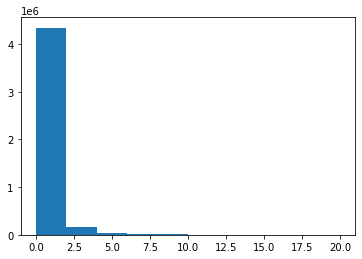

In [0]:
plt.hist(y_train)
#NOTE: Note outlier in training set (and not present in val set). -> not anymore using cleaned version of sales_train
#Reason why rmse worse in train than val set. 
#Also reason R2 better in train than val set (since normalised by the mean of each set in a sense) (so R2 for now more fairly shows the extend of overfitting)

(array([1.06573e+06, 3.65120e+04, 7.63500e+03, 2.82300e+03, 1.32300e+03,
        7.28000e+02, 5.01000e+02, 3.26000e+02, 2.32000e+02, 1.08100e+03]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.],
       dtype=float16),
 <a list of 10 Patch objects>)

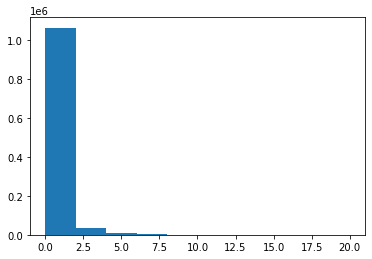

In [0]:
plt.hist(y_val)

In [0]:
print('Shape of X is ' + str(X_train.shape))
X_test.tail()

NameError: ignored

In [0]:
y_train.head()

2635    2.0
2636    0.0
2637    1.0
2638    0.0
2639    2.0
Name: item_cnt_month, dtype: float16

Model Specific feature set

In [0]:
#Remove categorical features unless encoded (e.g one-hot encoding) for basically any method other than a tree method (Linear Regresion, Neural Networks etc)
from sklearn.preprocessing import StandardScaler
LinRegFeaturesToDrop= ['date_block_num', 'shop_id', 'item_id', 'item_category_id']
scaler =  StandardScaler()

X_train_LinReg = scaler.fit_transform(X_train.drop(LinRegFeaturesToDrop, axis = 1))
X_val_LinReg = scaler.transform(X_val.drop(LinRegFeaturesToDrop, axis = 1))
X_test_LinReg = scaler.transform(X_test.drop(LinRegFeaturesToDrop, axis = 1))
feature_names_LinReg = X_train.drop(LinRegFeaturesToDrop, axis = 1).columns

In [15]:
feature_names = X_train.columns
X_train_np = X_train.to_numpy(dtype = np.float32)
del X_train
X_val_np = X_val.to_numpy(dtype = np.float32)
del X_val
X_test_np = X_test.to_numpy(dtype = np.float32)
del X_test
X_train_np.nbytes/(10**6)

1827.8292

**Model Fit & Validate**

Linear Regression

In [54]:
import sklearn
from sklearn.linear_model import LinearRegression
del X_train, X_val, X_test
X_train_model, X_val_model, X_test_model = X_train_LinReg, X_val_LinReg, X_test_LinReg
model = LinearRegression()
model.fit(X_train_model, y_train)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + ' R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + ' RMSE val_score is ' + str(val_rmse))

R^2 train_score is 0.26441780083320554 R^2 val_score is 0.24662758306712607
RMSE train_score is 1.0328629 RMSE val_score is 0.9334692


Feature Importance

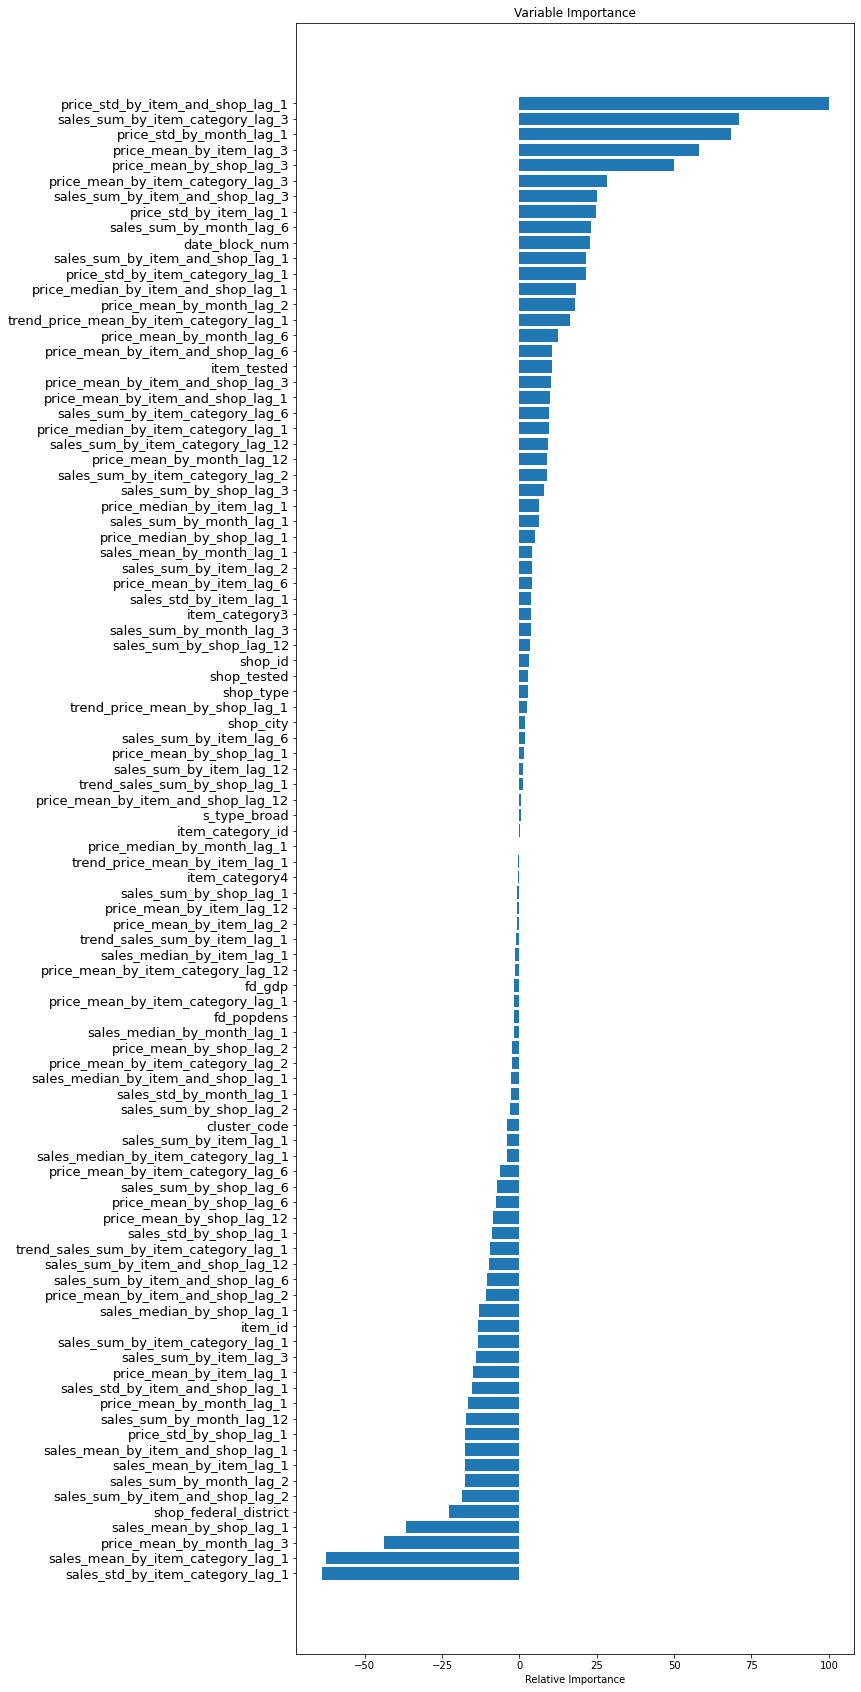

<Figure size 432x288 with 0 Axes>

In [49]:
feature_importance = model.coef_
# summarize feature importance
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,30)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
plt.savefig('LinReg_feature_importance.png')

In [0]:
X_train_LinReg.columns

Submission Prep

In [0]:
#Folder to save models and predictions
import os
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
folder_to_save = '/models_and_predictions'
os.chdir(gdrive_repo_path + folder_to_save)

In [52]:
import pickle
model_name = 'LinRegv4'


submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))
 
'''
# load the model from disk
loaded_model = pickle.load(open( model_name + '_model.sav', 'rb'))
print(result)
'''

"\n# load the model from disk\nloaded_model = pickle.load(open( model_name + '_model.sav', 'rb'))\nprint(result)\n"

In [0]:
submission.head()

,ID,item_cnt_month
0,0,0.620781
1,1,0.429811
2,2,0.416615
3,3,0.469035
4,4,0.434907


In [25]:
!pip install catboost
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import sklearn
import time 

LightGBM

In [21]:
X_train.values

array([[ 1.4000000e+01,  2.0000000e+00,  2.7000000e+01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4000000e+01,  2.0000000e+00,  2.8000000e+01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4000000e+01,  2.0000000e+00,  2.9000000e+01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 2.8000000e+01,  5.9000000e+01,  2.2164000e+04, ...,
        -5.0000000e-01, -2.5756836e-02,  5.3785272e-02],
       [ 2.8000000e+01,  5.9000000e+01,  2.2166000e+04, ...,
         0.0000000e+00, -2.5756836e-02,  5.3785272e-02],
       [ 2.8000000e+01,  5.9000000e+01,  2.2167000e+04, ...,
         0.0000000e+00, -2.5756836e-02,  5.3785272e-02]], dtype=float32)

R^2 train_score is 0.6036218549626118 R^2 val_score is 0.38532422909570074
RMSE train_score is 0.758101572121613 RMSE val_score is 0.8431757901375475
14.16929006576538


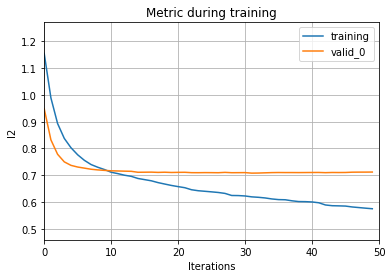

In [50]:
sampling_perc = 0.03 #percentage to sample out of total population of data points. 10**-4 takes 18 secs
random_indices = np.random.choice(len(X_train), int(len(X_train)*sampling_perc), replace = False)
X_train_model, X_val_model, X_test_model = X_train_np, X_val_np, X_test_np
X_train_model, y_train_model = X_train_model[random_indices], y_train[random_indices]

start = time.time()
model = LGBMRegressor(n_estimators=50, importance_type = 'gain', max_depth = 6, learning_rate = 0.3, reg_lambda=1.0)
model.fit(X_train_model, y_train_model, eval_set=[(X_val_model, y_val), (X_train_model, y_train_model)], verbose=0)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train_model, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train_model, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + ' R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + ' RMSE val_score is ' + str(val_rmse))
print(time.time()-start)

lgb.plot_metric(model)

In [48]:
#Folder to save models and predictions
model_name = 'LGBMv5'

import os
from google.colab import drive
drive.mount('/content/drive')
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
folder_to_save = '/models_and_predictions'
os.chdir(gdrive_repo_path + folder_to_save)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Feature Importance Analysis

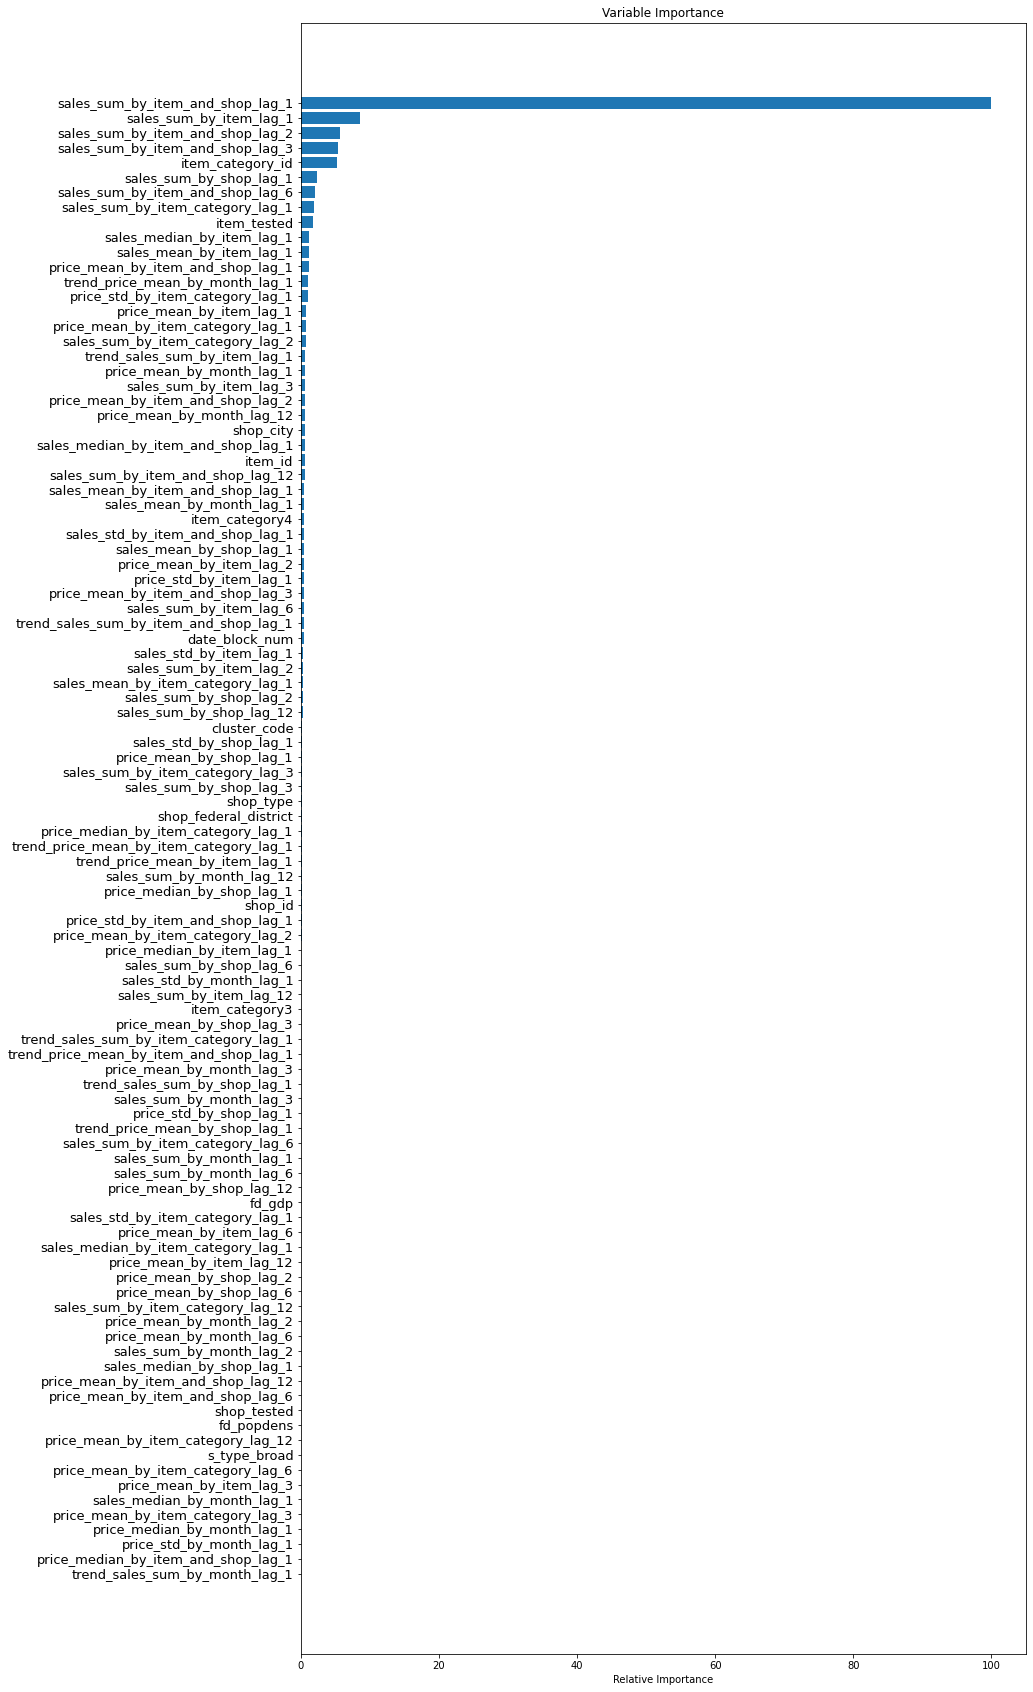

In [41]:
import matplotlib.pyplot as plt
# Plot feature importance - Results Visualization
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(13,30)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
#plt.savefig('gbt_feature_importance.png')

In [55]:
!pip install boruta
from boruta import BorutaPy
import numpy as np

In [0]:
from boruta import BorutaPy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor


start = time.time()
#ToDo: Can DOWNCAST to do more

#randomly sample data point - otherwise takes too long
sampling_perc = 0.15 #percentage to sample out of total population of data points. 10**-4 takes 18 secs
random_indices = np.random.choice(len(X_train), int(len(X_train)*sampling_perc), replace = False)

# Model for Boruta 
model_boruta = XGBRegressor(objective = 'reg:squarederror', n_estimators=15, seed=1) #For some reason LGBMRegressor and HistGradientBoostingRegressor don't seem to be compatible with Boruta. XGBRegressor, GradientBoostingRegressor, and RandomForestRegressor work (faster is XGBRegressor)
 
# Perform Boruta
boruta = BorutaPy(model_boruta, n_estimators='auto', verbose=2, max_iter = 40)
boruta.fit(X_train.values[random_indices], y_train.ravel()[random_indices])
end = time.time()

# Select features
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
# check ranking of features
best_features_ranked= X_train.columns[boruta.ranking_]

features_filtered = green_area + blue_area
print('features in the green area (confirmed):', green_area)
print('features in the blue area (tentative):', blue_area)
print('features order by importance:', best_features_ranked)
print('time taken is'  + str(start - end))

'''
Output with 1% and 75 iterations (max =100):
features in the green area (confirmed): ['sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_median_by_item_lag_1', 'sales_mean_by_item_and_shop_lag_1']
features in the blue area (tentative): []
time: 15mins

Output with 3% and 50 iterations:
features in the green area (confirmed): ['item_category_id', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'price_mean_by_month_lag_12', 'trend_sales_sum_by_month_lag_1']
features in the blue area (tentative): ['sales_sum_by_shop_lag_1', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_sum_by_month_lag_12', 'sales_median_by_item_lag_1', 'sales_median_by_item_and_shop_lag_1', 'trend_sales_sum_by_shop_lag_1']
time: 70mins

Output with 3% and 50 iterations:
features in the green area (confirmed): ['sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_2', 'price_mean_by_month_lag_12', 'sales_median_by_item_lag_1']
features in the blue area (tentative): ['price_median_by_item_lag_1', 'price_median_by_item_and_shop_lag_1', 'trend_price_mean_by_month_lag_1']
time: 57mins

Output with 3% and 50 iterations:
features in the green area (confirmed): ['item_tested', 'item_category_id', 'price_mean_by_item_lag_1', 'sales_sum_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_1', 'sales_sum_by_item_and_shop_lag_3', 'sales_sum_by_item_and_shop_lag_6', 'sales_sum_by_item_and_shop_lag_2', 'sales_sum_by_month_lag_12', 'price_median_by_item_lag_1']
features in the blue area (tentative): ['price_mean_by_item_lag_2', 'sales_sum_by_shop_lag_1', 'price_mean_by_item_and_shop_lag_1', 'price_mean_by_month_lag_6', 'sales_mean_by_month_lag_1', 'trend_price_mean_by_month_lag_1']


To do: run 1-2 more times with ranom samples to get more represenative of data (by considering outputs of all different data - i.e. their union)

'''

In [26]:
boruta.transform(X_train.values)

array([[  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       ...,
       [ 27. ,   2. ,   2. ,   1. ,   0. ,   1. ],
       [  4. ,   0. ,   0. ,   0. , 865.5,   1. ],
       [ 38. ,   0. ,   0. ,   0. , 865.5,   1. ]], dtype=float32)

In [20]:
print('features order by importance:', best_features_ranked)

features order by importance: Index(['sales_sum_by_shop_lag_3', 'sales_std_by_shop_lag_1',
       'price_mean_by_item_and_shop_lag_6', 'fd_gdp', 'item_category4',
       'sales_sum_by_item_category_lag_6', 'sales_mean_by_shop_lag_1',
       'sales_median_by_item_and_shop_lag_1',
       'price_std_by_item_and_shop_lag_1', 'price_mean_by_month_lag_6',
       'sales_sum_by_item_category_lag_2', 'sales_sum_by_month_lag_1',
       'price_median_by_item_and_shop_lag_1', 'sales_mean_by_month_lag_1',
       'price_mean_by_month_lag_6', 'item_category_id',
       'sales_mean_by_item_lag_1', 'sales_mean_by_item_lag_1',
       'price_std_by_item_lag_1', 'sales_sum_by_item_and_shop_lag_3',
       'shop_id', 'price_mean_by_shop_lag_2', 'price_mean_by_month_lag_1',
       'sales_median_by_item_and_shop_lag_1',
       'sales_sum_by_item_category_lag_1', 'shop_type',
       'sales_median_by_month_lag_1', 'price_mean_by_item_and_shop_lag_2',
       'trend_price_mean_by_item_lag_1', 'sales_sum_by_item_l

In [22]:
y_train.reshape(-1,1).shape

(4569573, 1)

Feature importance by time lag

In [0]:
pd_importance = pd.DataFrame({'importances': feature_importance[sorted_idx], 'names': feature_names[sorted_idx]})
df = pd_importance 
for i in range(len(TS_features)):
  if i == 0:
    df_mrg = df[df['names'].str.contains(TS_features[i])]
  else:
    df_2 = df[df['names'].str.contains(TS_features[i])]
    df_mrg = pd.concat([df_mrg, df_2], axis = 0)

df_mrg = df_mrg[~df_mrg.names.str.contains("trend")]
df_mrg['lags'] = df_mrg['names'].str.strip().str[-2:]
df_mrg['lags'] = df_mrg['names'].str.strip().str[-2:]
df_mrg['lags'] = df_mrg['lags'].str.replace(r'_', '')

,importances,names,lags
11,23.529412,price_mean_by_item_lag_1,1
12,8.403361,price_mean_by_item_lag_3,3
13,0.000000,price_mean_by_item_lag_6,6
14,1.260504,price_mean_by_item_lag_12,12
15,11.344538,price_mean_by_item_lag_2,2
...,...,...,...
56,0.000000,sales_sum_by_month_lag_1,1
57,0.000000,sales_sum_by_month_lag_3,3
58,0.000000,sales_sum_by_month_lag_6,6
59,0.000000,sales_sum_by_month_lag_12,12


In [0]:
#Feature Importance per lag
df_mrg.groupby(['lags']).mean().sort_values('importances', ascending=False)

,importances
lags,
1,32.112845
2,9.873950
3,8.673469
6,5.612245
12,4.051621


Feature importance by stats


> Time series features



In [0]:
#Stats of TS features (lags of 1,3,6, 12)
df_mrg['TS_stats'] = df_mrg['names'].apply(lambda st: st[st.find("_")+1:st.find("_by")])
df_mrg.groupby(['stats']).mean().sort_values('importances', ascending=False)

,importances
stats,
sum,17.515006
mean,6.614646




> Stats based features (just lag 1)



In [0]:
#Stats of Stats features (lag of 1)
#NOTE: Note that mean here appears in only half as much variables as std and median in Stats based features
df = pd_importance 
for i in range(len(Stats_features)):
  if i == 0:
    df_mrg_stats = df[df['names'].str.contains(Stats_features[i])]
  else:
    df_2 = df[df['names'].str.contains(Stats_features[i])]
    df_mrg_stats = pd.concat([df_mrg_stats, df_2], axis = 0)
df_mrg_stats['stats'] = df_mrg_stats['names'].apply(lambda st: st[st.find("_")+1:st.find("_by")])
df_mrg_stats.groupby(['stats']).mean().sort_values('importances', ascending=False)

,importances
stats,
mean,21.668667
std,13.925570
median,4.981993


Feature importance by "groupbys"

In [0]:
df_mrg_stats['groupby'] = df_mrg_stats['names'].apply(lambda st: st[st.find("by_")+3:st.find("_lag")])
df_mrg_stats.groupby(['groupby']).mean().sort_values('importances', ascending=False)

,importances
groupby,
item,26.050420
item_category,12.857143
item_and_shop,10.168067
month,7.142857
shop,4.033613


Feature importance by sales-based features vs price-based features

In [0]:
df = pd_importance 
iterable = ['price', 'sales']
for i in range(len(iterable)):
  if i == 0:
    df_mrg_2 = df[df['names'].str.startswith(iterable[i])]
  else:
    df_2 = df[df['names'].str.startswith(iterable[i])]
    df_mrg_2 = pd.concat([df_mrg_2, df_2], axis = 0)

df_mrg_2["sales_or_price"]= df["names"].str.slice(0, 5, 1) 

,importances,names,sales_or_price
11,23.529412,price_mean_by_item_lag_1,price
12,8.403361,price_mean_by_item_lag_3,price
13,0.000000,price_mean_by_item_lag_6,price
14,1.260504,price_mean_by_item_lag_12,price
15,11.344538,price_mean_by_item_lag_2,price
...,...,...,...
79,8.823529,sales_median_by_item_and_shop_lag_1,sales
80,14.705882,sales_mean_by_item_and_shop_lag_1,sales
83,10.084034,sales_std_by_month_lag_1,sales
84,0.000000,sales_median_by_month_lag_1,sales


In [0]:
df_mrg_2.groupby(['sales_or_price']).mean().sort_values('importances', ascending=False)

,importances
sales_or_price,
sales,15.451681
price,7.515006


Mean feature importance of trended features

In [0]:
df_trend = df[df['names'].str.contains("trend")]
df_trend.mean()

importances    8.697479
dtype: float64

Submission prep

In [147]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))

 
# load the model from disk
'''
loaded_model = pickle.load(open(model_file_name, 'rb'))
'''

"\nloaded_model = pickle.load(open(model_file_name, 'rb'))\n"

XGBoost - Gradient Boosting Tree

In [64]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

X_train_model, X_val_model, X_test_model = X_train_np, X_val_np, X_test_np

start = time.time()
model = XGBRegressor(max_depth = 6)
model.fit(np.array(X_train_model), y_train)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train_model).clip(0,20), model.predict(X_val_model).clip(0,20), model.predict(X_test_model).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + 'R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + 'RMSE val_score is ' + str(val_rmse))

KeyboardInterrupt: ignored

Feature Importance

In [19]:
import matplotlib.pyplot as plt
# Plot feature importance - Results Visualization
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(13,30)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()
#plt.savefig('gbt_feature_importance.png')

NameError: ignored

Sumbission prep

In [0]:
model_name = 'XGBv2'

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))

 
# load the model from disk
'''
loaded_model = pickle.load(open(model_file_name, 'rb'))
'''

"\nloaded_model = pickle.load(open(model_file_name, 'rb'))\nresult = loaded_model.score(X_test, Y_test)\nprint(result)\n"

CatBoost

In [0]:
model_name = 'catBoostv4'

# Prepare Categorical Variables
'''
categorical = []
for feature_engineered in features_engineered:
  categorical.append('above_12m_avg' + feature_engineered)

categorical.extend(['date_block_num','shop_id', 'item_id'])

def column_index(df, query_cols):
    indices = []
    for query_col in query_cols:
      index=df.columns.get_loc(query_col)
      indices.append(index)
    return indices
categorical_features_pos = column_index(X_train,categorical)
'''

EDA

In [0]:
data = matrix
df1 = data.describe(include = 'all')
df1.loc['dtype'] = data.dtypes
df1.loc['size'] = len(data)
df1.loc['% Null_count'] = data.isnull().mean()
df1

,date_block_num,shop_id,item_id
count,1.09138e+07,1.09138e+07,1.09138e+07
mean,14.9733,31.1872,11309.3
std,9.49562,17.3496,6209.98
min,0,0,0
25%,7,16,5976
50%,14,30,11391
75%,23,46,16605
max,33,59,22169
dtype,int8,int8,int16
size,10913850,10913850,10913850


**Data Cleaning**

In [0]:
#impute any potential missing values or deal with outliers

Feature Engineering

In [0]:
# To construct month, year feature from data
# count of days in a month
# time components of item_price and item_cnt (value at t-1, t-2, t-3, t-6, t-12 maybe)
# rate of change of item_cnt (between t-1 and t-2 e.g.), 
# statistics on item_price and item_cnt - mean, std, range, mode, skew?


In [0]:
#Create a distinct day, month, year column
'''
df['date'] = pd.to_datetime(df['date'], format = "%d.%m.%Y")
df['year'], df['month'], features['day'] = df['date'].dt.year, df['date'].dt.month, df['date'].dt.day
df.head()
'''
#also get day count (days in a month)